# Build a wind disturbance model

Use machine learning methods to build hurricane disturbance model - a general model

Author: Yanlei Feng

Start Date: Dec 16, 2020

This documentation aims to document the steps taken to train a hurricane disturbance model, which hopefully can be used in predictions of hurricanes' impacts on on trees .

## Import functions

In [1]:
# import packages and models
from skimage import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn import svm
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense

# set the random seed
np.random.seed(1)

# def all the functions used in the main code
def cleanextreme(data):
	"""
    data: numpy array
    columns: column index
    functions:
     1) clip DNPV to 0-1 range
     2) remove GV extreme value above 1 or below 0
     3) remove canopy height = 0, because the land cover map 
     used by Canopy height data were defined as non-forest, email by Marc Simard on May 26, 2020
     
    *Numpy array column name:
    # 0: "DNPV"
    # 1: "preGV"
    # 2: "elevation"
    # 3: "aspect"
    # 4: "slope"
    # 5: "CH"
    # 6: "precipitation"
    # 7: "foresttype"
    # 8: "wind"
    # 9: "topodiversity"
    #10: "landform"
    #11: "wetness"
    #12: "soilwater"
    #13: "soiltexture"
    """
    
    data = data[(data[:,0] < 1)&(data[:,0] > 0)] 
    data = data[(data[:,1] < 1)&(data[:,1] > 0)]
    data = data[(data[:,5] > 0)]
    return data

def digitize(k):
    """
    add a column of digitized y to categorical values
    use this digitized column to do stratified sampling
    """

    y_numerical = k[:,0] # Split y
    bins = np.array([0.0, .2, .4, .6, .8, 1.0])
    y_categorical = np.digitize(y_numerical, bins)
#     X_k = np.delete(k,0,1) # delete column_0 DNPV from data
    X_k = np.column_stack((y_categorical, k))    
    return X_k

def rmse(A, num):
    """
    select num of rows randomly from the data A
    reduce data size to better visualize
    """
    random.seed(30)
    idx = np.random.choice(A.shape[0], num, replace= True)
    k = A[idx]

    return k

#### 2. split X and Y
def split(k):
    """
    delete the first column
    split data into X and y
    """
    X_k = np.delete(k,0,1) # delete column_0 DNPV class
    y_k = X_k[:,0] # Split y
    X_k = np.delete(X_k,0,1) # seperate column_0 DNPV from data
        
    return X_k, y_k
# just check and see the counts of each categories
def stratify(all_hurricanes, num):
    """
    hurricanes: hurricane lists or single hurricane
    list: list of sample size of each categories
    """
    all_hurricanes_bycategories = [0 for i in range(5)]
    all_hurricanes_bycategories[0] = all_hurricanes[all_hurricanes[:,0] == 1.0]
    all_hurricanes_bycategories[1] = all_hurricanes[all_hurricanes[:,0] == 2.0]
    all_hurricanes_bycategories[2] = all_hurricanes[all_hurricanes[:,0] == 3.0]
    all_hurricanes_bycategories[3] = all_hurricanes[all_hurricanes[:,0] == 4.0]
    all_hurricanes_bycategories[4] = all_hurricanes[all_hurricanes[:,0] == 5.0]

    for category in all_hurricanes_bycategories:
        print ("All Hurricane y categories", category.shape)
    all_hurricanes_bycategories_random = [0 for i in range(5)]
    # sampling num samples from each categories
    for index, category in enumerate(all_hurricanes_bycategories):
        all_hurricanes_bycategories_random[index] = rmse(category, num[index])

    train_all = all_hurricanes_bycategories_random[0]
    for i in range(1,5):
        train_all = np.concatenate((train_all, all_hurricanes_bycategories_random[i]),axis = 0)
    return train_all

## 1. Data Collection
### 1. Import Data

In [80]:
# katrina = io.imread('Data/RegressionKatrina_07012020.tif')
katrina = io.imread('Data/RegressionKatrina_01062021_morehigh.tif')
rita = io.imread('Data/RegressionRita_07012020.tif')
yasi = io.imread('Data/RegressionYasi_07012020.tif')
maria = io.imread('Data/RegressionMaria_08282020.tif')
laura = io.imread('Data/RegressionLaura_12142020.tif')

### 2. Explore the dataset

In [81]:
m_katrina_size = katrina.shape
m_rita_size = rita.shape
m_yasi_size = yasi.shape
m_maria_size = maria.shape
m_laura_size = laura.shape
print ("Hurricane Katrina Image Size:" + str(m_katrina_size))
print ("Hurricane Rita Image Size:" + str(m_rita_size))
print ("Hurricane Yasi Image Size:" + str(m_yasi_size))
print ("Hurricane Maria Image Size:" + str(m_maria_size))
print ("Hurricane Laura Image Size:" + str(m_laura_size))

Hurricane Katrina Image Size:(3158, 3915, 14)
Hurricane Rita Image Size:(4681, 6289, 14)
Hurricane Yasi Image Size:(6445, 5443, 14)
Hurricane Maria Image Size:(2582, 6692, 14)
Hurricane Laura Image Size:(8107, 8440, 14)


### 3. Reshape the data

In [82]:
m_katrina_flatten = katrina.reshape(-1, katrina.shape[-1])
m_rita_flatten = rita.reshape(-1, rita.shape[-1])
m_yasi_flatten = yasi.reshape(-1, yasi.shape[-1])
m_maria_flatten = maria.reshape(-1, maria.shape[-1])
m_laura_flatten = laura.reshape(-1, laura.shape[-1])
print ("katrina flatten shape: " + str(m_katrina_flatten.shape))
print ("rita flatten shape: " + str(m_rita_flatten.shape))
print ("yasi flatten shape: " + str(m_yasi_flatten.shape))
print ("maria flatten shape: " + str(m_maria_flatten.shape))
print ("laura flatten shape: " + str(m_laura_flatten.shape))

katrina flatten shape: (12363570, 14)
rita flatten shape: (29438809, 14)
yasi flatten shape: (35080135, 14)
maria flatten shape: (17278744, 14)
laura flatten shape: (68423080, 14)


## 2. Data Cleaning
### 1. Clean the NaN

In [83]:
m_katrina_clean = m_katrina_flatten[~np.isnan(m_katrina_flatten).any(axis=1)]
m_rita_clean = m_rita_flatten[~np.isnan(m_rita_flatten).any(axis=1)]
m_yasi_clean = m_yasi_flatten[~np.isnan(m_yasi_flatten).any(axis=1)]
m_maria_clean = m_maria_flatten[~np.isnan(m_maria_flatten).any(axis=1)]
m_laura_clean = m_laura_flatten[~np.isnan(m_laura_flatten).any(axis=1)]

print ("katrina clean NaN shape: " + str(m_katrina_clean.shape))
print ("rita clean NaN shape: " + str(m_rita_clean.shape))
print ("yasi clean NaN shape: " + str(m_yasi_clean.shape))
print ("maria clean NaN shape: " + str(m_maria_clean.shape))
print ("laura clean NaN shape: " + str(m_laura_clean.shape))

katrina clean NaN shape: (5116811, 14)
rita clean NaN shape: (14109974, 14)
yasi clean NaN shape: (6245182, 14)
maria clean NaN shape: (3061644, 14)
laura clean NaN shape: (18587134, 14)


### 2. Clean the extreme values

In [84]:
katrina = cleanextreme(m_katrina_clean)
rita = cleanextreme(m_rita_clean)
yasi = cleanextreme(m_yasi_clean)
maria = cleanextreme(m_maria_clean)
laura = cleanextreme(m_laura_clean)

print("katrina clean extreme shape: " + str(katrina.shape))
print("rita clean extreme shape: " + str(rita.shape))
print("yasi clean extreme shape: " + str(yasi.shape))
print("maria clean extreme shape: " + str(maria.shape))
print("laura clean extreme shape: " + str(laura.shape))

katrina clean extreme shape: (4331427, 14)
rita clean extreme shape: (4608972, 14)
yasi clean extreme shape: (3879752, 14)
maria clean extreme shape: (2644376, 14)
laura clean extreme shape: (11984398, 14)


## 3. do some data exploration

### 3.1 scatter plots of wind and DNPV across all hurricanes

In [5]:
rita_sampling = rmse(rita, 5000)
katrina_sampling = rmse(katrina, 5000)
yasi_sampling = rmse(yasi, 5000)
maria_sampling = rmse(maria, 5000)
laura_sampling = rmse(laura, 5000)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True)
fig.suptitle('Wind and disturbance')

ax1.scatter(katrina_sampling[:,8],katrina_sampling[:,0], color = 'k', s = 0.5, alpha=1)
ax1.set_xlim(19.05, 55.05)
ax1.set_ylim(-0.05, 1.05)
ax1.set_xlabel("Wind")
ax1.set_ylabel("DNPV")

ax2.scatter(rita_sampling[:,8],rita_sampling[:,0], color = 'k', s = 0.5, alpha=1)
ax3.scatter(yasi_sampling[:,8],yasi_sampling[:,0], color = 'k', s = 0.5, alpha=1)
ax4.scatter(maria_sampling[:,8],maria_sampling[:,0], color = 'k', s = 0.5, alpha=1) 
ax4.set_xlim(19.05, 85.05)
ax5.scatter(laura_sampling[:,8],laura_sampling[:,0], color = 'k', s = 0.5, alpha=1)

NameError: name 'rmse' is not defined

### 3.2 scatter plots of wind distribution of Rita and Laura

In [4]:
# hurricane Rita vs. Laura
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.scatter(rita_sampling[:,8],rita_sampling[:,0], color = 'k', s = 0.5, alpha=1)
ax1.set_title("Hurricane Rita")
ax1.set_ylabel("DNPV")
ax2.scatter(laura_sampling[:,8],laura_sampling[:,0], color = 'k', s = 0.5, alpha=1)
ax2.set_xlim(15.05, 55.05)
ax2.set_ylim(-0.05, 1.05)
ax2.set_xlabel("Wind (m/s)")
ax2.set_ylabel("DNPV")
ax2.set_title("Hurricane Laura")

NameError: name 'plt' is not defined

### 3.3 scatter plots of precipitation distribution of Rita and Laura

Text(0.5, 1.0, 'Hurricane Laura')

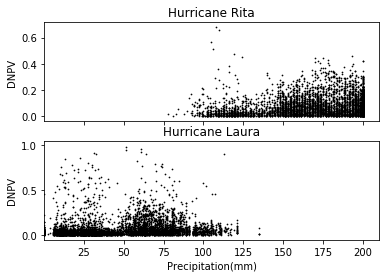

In [88]:
# Precipitation
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.scatter(rita_sampling[:,6],rita_sampling[:,0], color = 'k', s = 0.5, alpha=1)
ax1.set_title("Hurricane Rita")
ax1.set_ylabel("DNPV")
ax2.scatter(laura_sampling[:,6],laura_sampling[:,0], color = 'k', s = 0.5, alpha=1)
ax2.set_xlim(0.05, 210.05)
ax2.set_ylim(-0.05, 1.05)
ax2.set_xlabel("Precipitation(mm)")
ax2.set_ylabel("DNPV")
ax2.set_title("Hurricane Laura")

## 4. Data preparation 

### 4.1 stratified sampling

In [92]:
# combine 4 hurricanes together
hurricane_list_all = [katrina, rita, yasi, maria, laura]
hurricane_name_list = ["Katrina", "Rita", "Yasi", "Maria", "laura"]

hurricane_list_all_multiclass = [0 for i in range(len(hurricane_list_all))]

# digitize y values to categorical data for stratified sampling
for i in range(len(hurricane_list_all)):
    random.seed(30)
    hurricane_list_all_multiclass[i] = digitize(hurricane_list_all[i]) #store array in lists
    np.set_printoptions(suppress=True, precision=3)
    print("hurricane " + hurricane_name_list[i] + " size: ", hurricane_list_all_multiclass[i].shape)


hurricane Katrina size:  (4331427, 15)
hurricane Rita size:  (4608972, 15)
hurricane Yasi size:  (3879752, 15)
hurricane Maria size:  (2644376, 15)
hurricane laura size:  (11984398, 15)


### 4.2 stratified sampling and oversampling intensive disturbance

#### 4.2.1 three different hurricane combination for training data, uncomment to chosse one of them

In [93]:
# 1) stack all four hurricanes together
# all_hurricanes = np.concatenate((hurricane_list_all_multiclass[0], hurricane_list_all_multiclass[1], hurricane_list_all_multiclass[2], hurricane_list_all_multiclass[3]), axis=0)
# test_hurricane = hurricane_list_all_multiclass[4]

# 2) use only katrina data
all_hurricanes = (hurricane_list_all_multiclass[0])
test_hurricane = hurricane_list_all_multiclass[0]

# 3) train with laura and rita only
# all_hurricanes = np.concatenate((hurricane_list_all_multiclass[4],  hurricane_list_all_multiclass[0]))
# test_hurricane = hurricane_list_all_multiclass[1]

# check the shape
print("all hurricanes stack's shape", all_hurricanes.shape)
print("disturbance 0-0.2", all_hurricanes[all_hurricanes[:,0]==1].shape)
print("disturbance 0.2-0.4", all_hurricanes[all_hurricanes[:,0]==2].shape)
print("disturbance 0.4-0.6", all_hurricanes[all_hurricanes[:,0]==3].shape)
print("disturbance 0.6-0.8", all_hurricanes[all_hurricanes[:,0]==4].shape)
print("disturbance 0.8-1.0", all_hurricanes[all_hurricanes[:,0]==5].shape)

all hurricanes stack's shape (4331427, 15)
disturbance 0-0.2 (3738976, 15)
disturbance 0.2-0.4 (542289, 15)
disturbance 0.4-0.6 (45363, 15)
disturbance 0.6-0.8 (4341, 15)
disturbance 0.8-1.0 (458, 15)


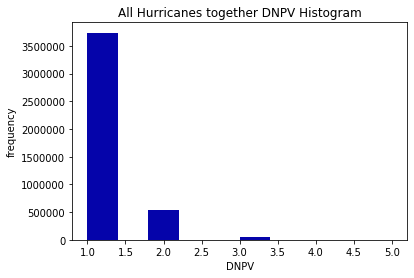

In [94]:
# plot the y distribution to double check
plt.hist(all_hurricanes[:,0], color='#0504aa')
plt.title('All Hurricanes together DNPV Histogram')
plt.ylabel("frequency")
plt.xlabel("DNPV")
plt.show()

#### 4.2.2 Different sampling methods

In [95]:
# sampling 1
# non-stratify random sampling
# train_all = rmse(all_hurricanes, 50000)
# test_all = rmse(test_hurricane, 5000)

# samlpling 2
# # stratified sampling by y categories
# # prepare data for training and test
# train_stratify = [10000,10000,10000,10000,10000]
# test_stratify = [1000,1000,1000,1000,1000]
# train_all = stratify(all_hurricanes,train_stratify)
# test_all = stratify(test_hurricane,test_stratify)

# samlpling 3
# stratified sampling accordingly
train_stratify_decreasing = [32000,16000,8000,4000,2000]
test_stratify_decreasing = [3200,1600,800,400,200]
train_all = stratify(all_hurricanes,train_stratify_decreasing)
test_all = stratify(test_hurricane,test_stratify_decreasing)

# samlpling 4
# random sampling only intensive disturbance (upper 50%)
p75 = np.percentile(all_hurricanes[:,1],75)
p50 = np.median(all_hurricanes[:,1])
print(p75, "p75")
print(p50, "p50")

# check the shape of sampled data
print(all_hurricanes[(all_hurricanes[:,1]>0.3)].shape)
print(test_hurricane[(test_hurricane[:,1]>0.3)].shape)

All Hurricane y categories (3738976, 15)
All Hurricane y categories (542289, 15)
All Hurricane y categories (45363, 15)
All Hurricane y categories (4341, 15)
All Hurricane y categories (458, 15)
All Hurricane y categories (3738976, 15)
All Hurricane y categories (542289, 15)
All Hurricane y categories (45363, 15)
All Hurricane y categories (4341, 15)
All Hurricane y categories (458, 15)
0.1536712944507599 p75
0.09575909376144409 p50
(160708, 15)
(160708, 15)


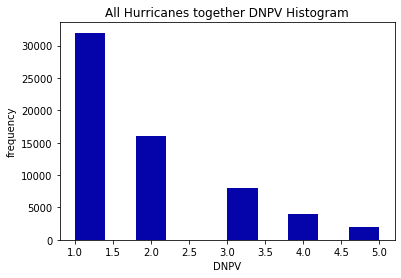

In [96]:
# plot the y distribution to double check
plt.hist(train_all[:,0], color='#0504aa')
plt.title('All Hurricanes together DNPV Histogram')
plt.ylabel("frequency")
plt.xlabel("DNPV")
plt.show()

## 5. model

### 5.1 split x and y and double check data

In [97]:
# split features and label
X_hurricane_general_train, y_hurricane_general_train = split(train_all)
# set up test data
X_hurricane_general_test, y_hurricane_general_test = split(test_all)
# split train, test
# X_hurricane_general_train, X_hurricane_general_test, y_hurricane_general_train, y_hurricane_general_test = train_test_split(hurricane_general_X, hurricane_general_y, test_size=0.02, shuffle = True, random_state=42)
print( "general hurricane training data  X total", X_hurricane_general_train.shape)
print( "general hurricane test data X total", X_hurricane_general_test.shape)
print( "check y", y_hurricane_general_train[:10])
print( "check test y", y_hurricane_general_test[:10])

general hurricane training data  X total (62000, 13)
general hurricane test data X total (6200, 13)
check y [0.106 0.068 0.026 0.129 0.14  0.125 0.119 0.019 0.019 0.013]
check test y [0.094 0.166 0.079 0.162 0.019 0.065 0.168 0.036 0.064 0.064]


(array([19514., 12487., 12715.,  3284.,  5988.,  2012.,  3305.,   695.,
         1260.,   740.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

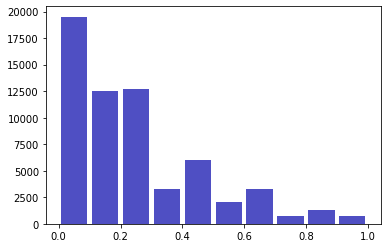

In [98]:
# plot y value to double check
plt.hist(y_hurricane_general_train, color='#0504aa', alpha=0.7, rwidth=0.85)

### 5.2 Feature Scaling
The test data is unseen, so we use mean and sigma from training data to normalize test set

1.) normalize the training set and save the normalization parameters<br/>
2.) normalize the test set using the training normalization parameters

#### 5.2.1 Standard normalization 


In [99]:
# np.set_printoptions(formatter={'float_kind':'{:f}'.format})
# standard normalization z = (X-miu)/sigma
scaler = StandardScaler()
    
# for the general model
train_scaled = scaler.fit_transform(X_hurricane_general_train)
test_scaled = scaler.transform(X_hurricane_general_test)


#### 5.2.2 OneHotEncoder
apply oneHotEncoder to the foresttype column<br/>
Those columns specified with passthrough are added at the right to the output of the transformers.

In [100]:
ct = ColumnTransformer([('encoder', OneHotEncoder(), [6])], remainder = 'passthrough')

# for the general hurricane model
X_train = ct.fit_transform(train_scaled)
X_test_newhurr = ct.transform(test_scaled)

# After OneHotEncoder, variables become:
    # 0-16: "foresttype"
    # 17: "preGV"
    # 18: "elevation"
    # 19: "aspect"
    # 20: "slope"
    # 21: "CH"
    # 22: "precipitation"
    # 23: "wind"
    # 24: "topodiversity"
    # 25: "landform"
    # 26: "wetness"
    # 27: "soilwater"
    # 28: "soiltexture"
    
# test log transform right skewed data
# y_test_newhurr = np.log(y_hurricane_general_test)

# no transfer on y value
y_test_newhurr = (y_hurricane_general_test)
y_train = (y_hurricane_general_train)

# get number of features after encoding
nrows, ncols = X_train.shape
# for the general model

print("Data are correctly splited and encoded, Yeah!")

Data are correctly splited and encoded, Yeah!


### 5.3 Train test split

In [101]:
X_train,  X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1)
print( "Training samples X: " + str(X_train.shape) + ", y: " + str(y_train.shape))
print( "Test samples X: " + str(X_test.shape) + ", y: " + str(y_test.shape))
print( "Test new hurricane samples X: " + str(X_test_newhurr.shape) + ", y: " + str(y_test_newhurr.shape))

Training samples X: (41540, 13), y: (41540,)
Test samples X: (20460, 13), y: (20460,)
Test new hurricane samples X: (6200, 13), y: (6200,)


### 5.4 Modeling

#### 5.4.1 Hold out test result

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import balanced_accuracy_score
import seaborn as sns
from scipy.stats import pearsonr
rf = RandomForestRegressor(n_estimators=100, max_features = "sqrt",random_state = 30)
rf.fit(X_train, y_train)
prediction_test_rf = rf.predict(X_test)
importance_rf = rf.feature_importances_
mse_test_rf = np.sqrt(np.mean(np.square(y_test - prediction_test_rf))) #calculate root mean square error
corr, _ = pearsonr(y_test, prediction_test_rf)
r2 = rf.score(X_test,y_test)


print("rmse_test RF", mse_test_rf)
print("feature importance", rf.feature_importances_)
print('Pearsons correlation: %.3f' % corr)
print("r2", r2)

print("training errors")
print(np.sqrt(np.mean(np.square(y_train-rf.predict(X_train)))))
print(rf.score(X_train, y_train))

rmse_test RF 0.07998462529586096
feature importance [0.112 0.086 0.019 0.026 0.056 0.16  0.05  0.205 0.06  0.026 0.102 0.059
 0.039]
Pearsons correlation: 0.929
r2 0.8599290185434822


#### 5.4.2 Overfitting test

In [56]:
# check if the model is overfitting
# define lists to collect scores
train_scores, test_scores = [], []

# define the tree depths to evaluate
values = [i for i in range(90, 1100, 100)]
# evaluate a decision tree for each depth
for i in values:
    train_acc = 0
    test_acc = 0
    # configure the model
    model = RandomForestRegressor(n_estimators=i)
#     model = RandomForestRegressor(n_estimators=1000, random_state = 30)
    # fit model on the training dataset
    model.fit(X_train, y_train)
    # evaluate on the train dataset
    train_ypre = model.predict(X_train)
    train_acc = np.sqrt(np.mean(np.square(y_train-train_ypre)))
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_ypre = model.predict(X_test)
    test_acc = np.sqrt(np.mean(np.square(y_test-test_ypre)))
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
    print('r2',model.score(X_test,y_test))

>90, train: 0.062, test: 0.164
r2 0.49714173351272267
>190, train: 0.060, test: 0.163
r2 0.501384243464382
>290, train: 0.060, test: 0.164
r2 0.49995034553766865
>390, train: 0.060, test: 0.163
r2 0.5031771516125183
>490, train: 0.060, test: 0.163
r2 0.5023869984059486
>590, train: 0.060, test: 0.163
r2 0.5030254945946568
>690, train: 0.060, test: 0.163
r2 0.5030888962659117
>790, train: 0.060, test: 0.163
r2 0.5042552440835473
>890, train: 0.060, test: 0.163
r2 0.5040757436693675
>990, train: 0.060, test: 0.163
r2 0.503492362795038
>1090, train: 0.060, test: 0.163
r2 0.5036018861331306


#### 5.4.3 Cross validation

In [100]:
rmse_scores = cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=4)
print(rmse_scores)
r2_scores = cross_val_score(rf, X_train, y_train, cv=4)
print(r2_scores)

[-0.084 -0.084 -0.083 -0.085]
[0.457 0.438 0.436 0.424]


In [101]:
# cross validation average
print("stratified sampling")
print("rmse mean", np.mean(rmse_scores))
print("r2 mean", np.mean(r2_scores))

stratified sampling
rmse mean -0.08385422446974086
r2 mean 0.438446564425532


###  5.5 Plot the figures between observed value and predicted value

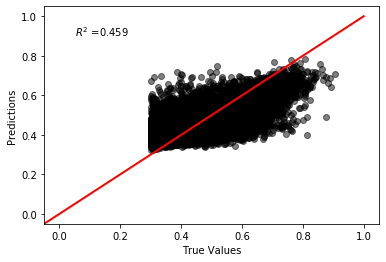

In [102]:
# plot correlation between prediction and true values
plt.figure()
plt.scatter(y_test, prediction_test_rf, color = 'k', alpha=0.5)
plt.plot([-1, 1], [-1, 1], color = 'red', linewidth = 2)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
r2 = np.round(r2, 3)
plt.text(0.05, 0.9, r'$R^{2}$ ='+str(r2))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

### 5.6 Plot the feature importance

ValueError: shape mismatch: objects cannot be broadcast to a single shape

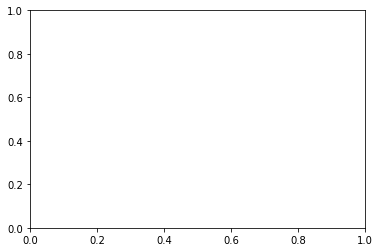

In [25]:
    # 0: "preGV    # 1: "elevation"    # 2: "aspect"    # 3: "slope"
    # 4: "CH"      # 5: "precipitation"# 6: "foresttype"# 7: "wind"
    # 8: "topodiversity"#9: "landform"#10: "wetness"   #11: "soilwater"
    #12: "soiltexture"
    #plot feature importance
    # plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],importance_rf)


plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12],importance_rf)
plt.title(" Feature Importance")
plt.xlabel("features")
plt.ylabel("importance")
plt.show()

## 6. Test the hurricane model on an unseen hurricane

In [74]:
# Test the general random forest model on a new hurricane
prediction_newhurr_rf = rf.predict(X_test_newhurr)
mse_newhurr_rf = np.sqrt(np.mean(np.square(y_test_newhurr - prediction_newhurr_rf))) #calculate root mean square error
print("rmse_test RF", mse_newhurr_rf)
corr_newhurr, _ = pearsonr(y_test_newhurr, prediction_newhurr_rf)
r2_newhurr = rf.score(X_test_newhurr, y_test_newhurr)
print('Pearsons correlation: %.3f' % corr_newhurr)
print("r2 new hurr", r2_newhurr)

rmse_test RF 0.24417545547053138
Pearsons correlation: 0.090
r2 new hurr -0.0617624406413364


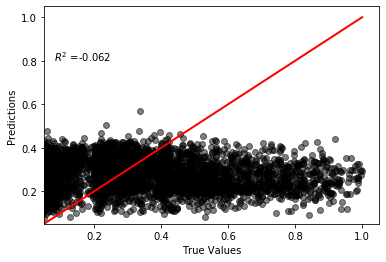

In [77]:
# plot correlation between prediction and true values
plt.figure()
plt.scatter(test_concat[:,0], test_concat[:,1], color = 'k', alpha=0.5)
plt.plot([0, 1], [0, 1], color = 'red', linewidth = 2)
plt.xlim(0.05, 1.05)
plt.ylim(0.05, 1.05)
plt.text(0.08, 0.8, r'$R^{2}$ ='+str(round(r2_newhurr,3)))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

test_error_mean =-0.037614331044302986; test_error_std =0.24126088608460974


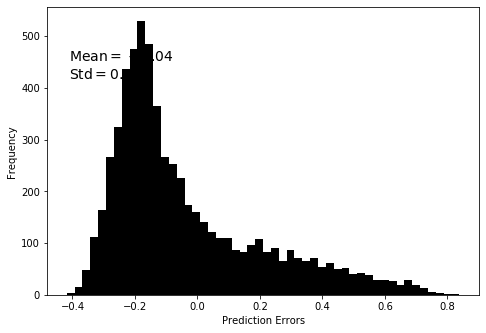

In [78]:
# plot test error with mean and std

# calculate the test error mean and std
test_error = test_concat[:,0]-test_concat[:,1]
test_error_mean = np.mean(test_error)
test_error_std = np.std(test_error)
print("test_error_mean ="+str(test_error_mean) +"; test_error_std ="+ str(test_error_std))

# plot the error
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.hist(test_error, color = 'k', bins = 50)
textstr = '\n'.join((
    r'$\mathrm{Mean} =%.2f$' % (test_error_mean, ),
    r'$\mathrm{Std}=%.2f$' % (test_error_std, )))

ax.text(0.05, 0.85, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

ax.set_xlabel('Prediction Errors')
ax.set_ylabel('Frequency')
plt.show()